# Dynamical systems example in numpyro

## Debug

## Setup

### Import libraries

In [12]:
import platform
from inspect import getmembers
from pprint import pprint
from types import FunctionType

import arviz as az
import jax
import jax.numpy as jnp
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

In [13]:
from jax.experimental.ode import odeint
from numpyro.examples.datasets import LYNXHARE, load_dataset
from numpyro.infer import MCMC, NUTS, Predictive

In [14]:
numpyro.set_platform("cpu")
numpyro.set_host_device_count(4)

In [15]:
print(platform.python_version())
print(numpyro.__version__)
print(jax.__version__)
print(az.__version__)

3.10.12
0.12.1
0.4.11
0.15.1


In [16]:
# print("Numpyro platform:", numpyro.get_platform())
print("JAX backend:", jax.devices())

JAX backend: [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3)]


### Setup plotting

In [17]:
import matplotlib.font_manager
import matplotlib.pyplot as plt

# import matplotlib_inline

In [18]:
fonts_path = "/usr/share/texmf/fonts/opentype/public/lm/" #ubuntu
# fonts_path = "~/Library/Fonts/" # macos
# fonts_path = "/usr/share/fonts/OTF/"  # arch
matplotlib.font_manager.fontManager.addfont(fonts_path + "lmsans10-regular.otf")
matplotlib.font_manager.fontManager.addfont(fonts_path + "lmroman10-regular.otf")

In [19]:
# https://stackoverflow.com/a/36622238/446907
%config InlineBackend.figure_formats = ['svg']

In [20]:
plt.style.use("default")  # reset default parameters
# https://stackoverflow.com/a/3900167/446907
plt.rcParams.update(
    {
        "font.size": 16,
        "font.family": ["sans-serif"],
        "font.serif": ["Latin Modern Roman"] + plt.rcParams["font.serif"],
        "font.sans-serif": ["Latin Modern Sans"] + plt.rcParams["font.sans-serif"],
    }
)

### Utility functions

In [21]:
def attributes(obj):
    disallowed_names = {
        name for name, value in getmembers(type(obj)) if isinstance(value, FunctionType)
    }
    return {
        name: getattr(obj, name)
        for name in dir(obj)
        if name[0] != "_" and name not in disallowed_names and hasattr(obj, name)
    }


def print_attributes(obj):
    pprint(attributes(obj))

## Execute

### Define sample data

In [22]:
_, fetch = load_dataset(LYNXHARE, shuffle=False)
year, data = fetch()  # data is in hare -> lynx order

In [23]:
type(year), year.shape, year.dtype

(jaxlib.xla_extension.ArrayImpl, (91,), dtype('int32'))

In [24]:
type(data), data.shape, data.dtype

(jaxlib.xla_extension.ArrayImpl, (91, 2), dtype('float32'))

### Define model

#### Simulate dynamical system

In [25]:
def dz_dt(z, t, theta):
    """
    Lotka–Volterra equations. Real positive parameters `alpha`, `beta`, `gamma`, `delta`
    describes the interaction of two species.
    """
    u = z[0]
    v = z[1]
    alpha, beta, gamma, delta = (
        theta[..., 0],
        theta[..., 1],
        theta[..., 2],
        theta[..., 3],
    )
    du_dt = (alpha - beta * v) * u
    dv_dt = (-gamma + delta * u) * v
    return jnp.stack([du_dt, dv_dt])


#### Define probabilistic model

In [26]:
def model(N, y=None):
    """
    :param int N: number of measurement times
    :param numpy.ndarray y: measured populations with shape (N, 2)
    """
    # initial population
    z_init = numpyro.sample("z_init", dist.LogNormal(jnp.log(10), 1).expand([2]))
    # measurement times
    ts = jnp.arange(float(N))
    # parameters alpha, beta, gamma, delta of dz_dt
    theta = numpyro.sample(
        "theta",
        dist.TruncatedNormal(
            low=0.0,
            loc=jnp.array([1.0, 0.05, 1.0, 0.05]),
            scale=jnp.array([0.5, 0.05, 0.5, 0.05]),
        ),
    )
    # integrate dz/dt, the result will have shape N x 2
    z = odeint(dz_dt, z_init, ts, theta, rtol=1e-6, atol=1e-5, mxstep=1000)
    # measurement errors
    sigma = numpyro.sample("sigma", dist.LogNormal(-1, 1).expand([2]))
    # measured populations
    numpyro.sample("y", dist.LogNormal(jnp.log(z), sigma), obs=y)


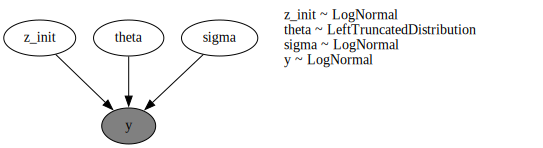

In [27]:
numpyro.render_model(
    model, model_args=(data.shape[0], data,), render_distributions=True, render_params=True
)

#### Plot priors

In [29]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = jax.random.PRNGKey(0)
rng_key, rng_key_ = jax.random.split(rng_key)

In [30]:
rng_key, rng_key_ = jax.random.split(rng_key)
prior_predictive = Predictive(model, num_samples=1000)
prior_predictions = prior_predictive(rng_key_, data.shape[0])

In [31]:
idata_prior = az.from_numpyro(posterior=None, prior=prior_predictions)

In [41]:
idata_prior

Inference data with groups:
	> prior

In [49]:
light_gray = (0.7,0.7,0.7)

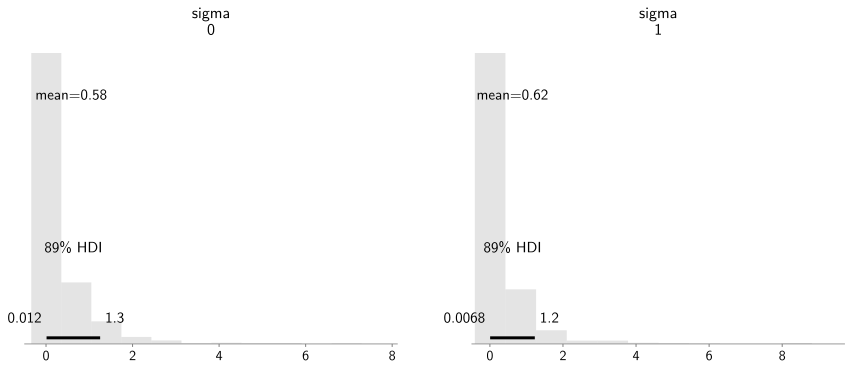

In [50]:
az.plot_posterior(idata_prior, var_names=["sigma"], group="prior", kind="hist", round_to=2, hdi_prob=0.89, color=light_gray);

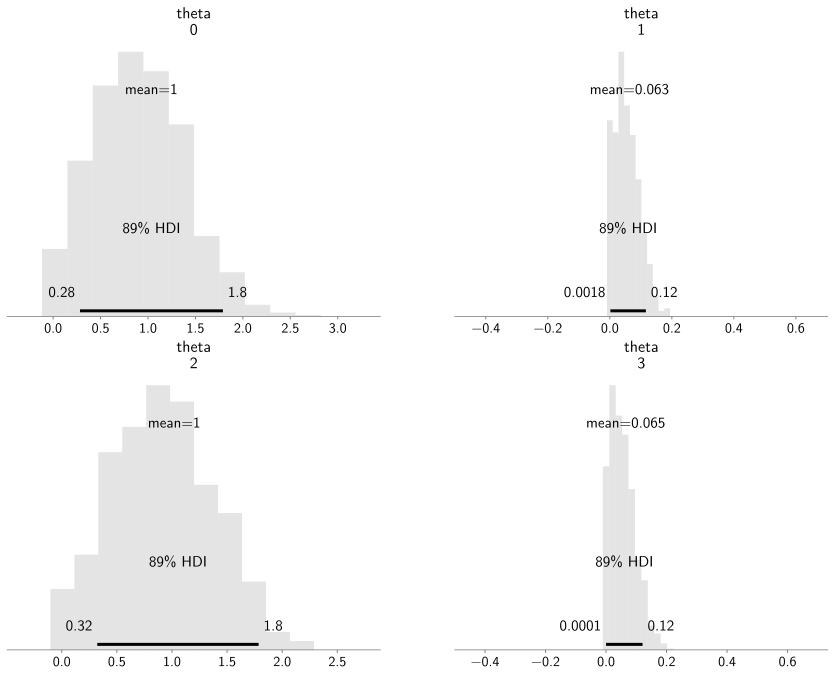

In [51]:
az.plot_posterior(idata_prior, var_names=["theta"], grid=(2,2), group="prior", kind="hist", round_to=2, hdi_prob=0.89, color=light_gray);

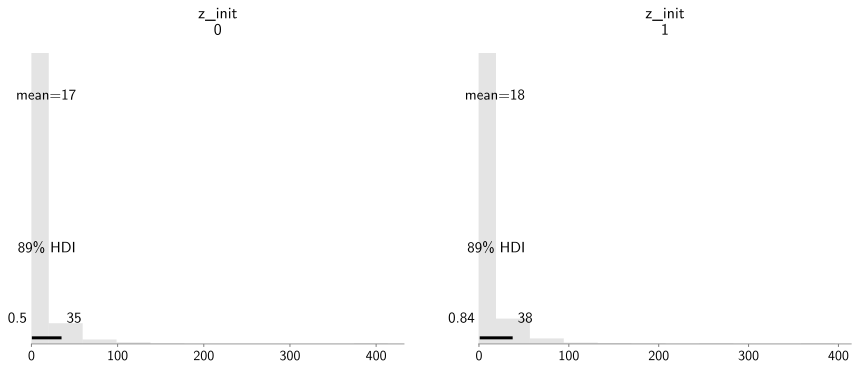

In [52]:
az.plot_posterior(idata_prior, var_names=["z_init"], grid=(1,2), group="prior", kind="hist", round_to=2, hdi_prob=0.89, color=light_gray);

### Fit model

In [28]:
R = 1000

In [157]:
kernel = NUTS(model, dense_mass=True)
mcmc = MCMC(
    kernel, num_warmup=1000, num_samples=R, num_chains=1, chain_method="parallel"
)

In [158]:
mcmc.run(rng_key_, N=data.shape[0], y=data)

warmup:   2%|▏         | 45/2000 [01:16<55:04,  1.69s/it, 1023 steps of size 1.79e-06. acc. prob=0.66]  


KeyboardInterrupt: 

In [91]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma[0]      1.04      0.08      1.03      0.91      1.17    807.64      1.00
  sigma[1]      0.52      0.04      0.52      0.45      0.57    965.35      1.00
  theta[0]      0.49      0.11      0.48      0.30      0.65    254.01      1.00
  theta[1]      0.02      0.00      0.02      0.01      0.03    257.50      1.00
  theta[2]      0.99      0.23      0.95      0.65      1.35    437.51      1.00
  theta[3]      0.03      0.01      0.03      0.02      0.05    654.02      1.00
 z_init[0]     51.25      9.06     50.35     37.56     65.87   1022.32      1.00
 z_init[1]     34.59      5.87     34.34     23.99     42.92    419.31      1.00

Number of divergences: 3


In [92]:
posterior_samples = mcmc.get_samples(group_by_chain=False)

In [93]:
rng_key, rng_key_ = jax.random.split(rng_key)
posterior_predictive = Predictive(model, posterior_samples)
posterior_predictions = posterior_predictive(rng_key_, data.shape[0])

In [94]:
[v.shape for k, v in posterior_predictions.items()]

[(1000, 91, 2)]

In [142]:
rng_key, rng_key_ = jax.random.split(rng_key)
prior_predictive = Predictive(model, num_samples=1000)
prior_predictions = prior_predictive(rng_key_, data.shape[0])

In [143]:
[v.shape for k, v in prior_predictions.items()]

[(1000, 2), (1000, 4), (1000, 91, 2), (1000, 2)]

### Organize output data

In [97]:
type(mcmc)

numpyro.infer.mcmc.MCMC

In [98]:
inferencedata = az.from_numpyro(
    mcmc,
    prior=prior_predictions,
    posterior_predictive=posterior_predictions,
)

In [36]:
inferencedata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

### Evaluate model

#### Plot autocorrelation to evaluate MCMC chain mixing

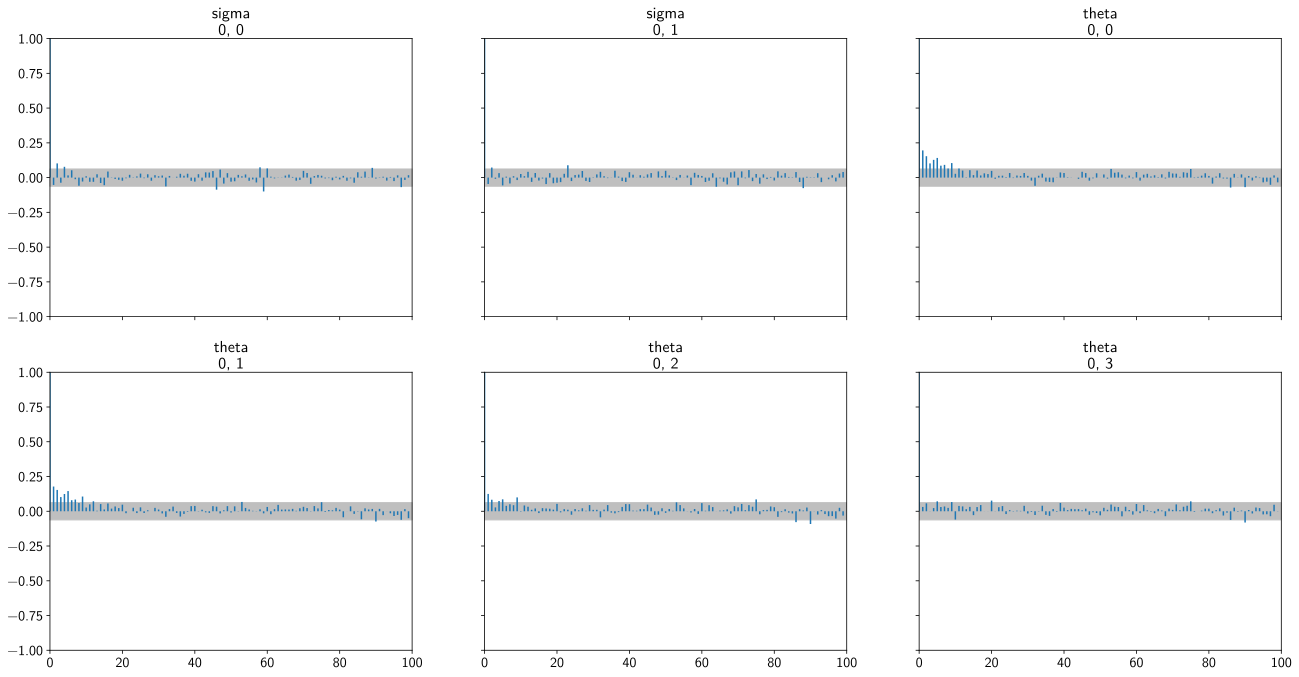

In [101]:
# with model:
az.plot_autocorr(inferencedata, var_names=["sigma", "theta"]);

#### Plot prior and posterior predictive distributions

/opt/conda/envs/api/lib/python3.10/site-packages/numpy/lib/shape_base.py:1270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = _nx.array(A, copy=False, subok=True, ndmin=d)
/opt/conda/envs/api/lib/python3.10/site-packages/numpy/lib/shape_base.py:1270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = _nx.array(A, copy=False, subok=True, ndmin=d)


(1, 2)


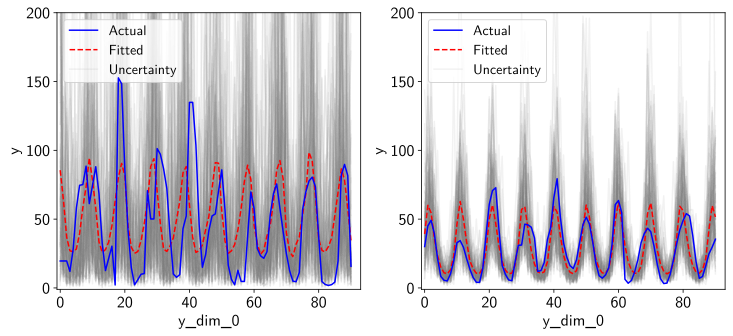

In [139]:
ax_postpc = az.plot_ts(inferencedata, y="y", plot_dim="y_dim_0");
for ax in ax_postpc[0]:
    ax.set_xlim([-1, 93])
    ax.set_ylim([-1, 200])

In [144]:
idataprior = az.from_numpyro(
    mcmc,
    prior=prior_predictions,
    posterior_predictive={"y": prior_predictions["y"]}
)

/opt/conda/envs/api/lib/python3.10/site-packages/numpy/lib/shape_base.py:1270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = _nx.array(A, copy=False, subok=True, ndmin=d)


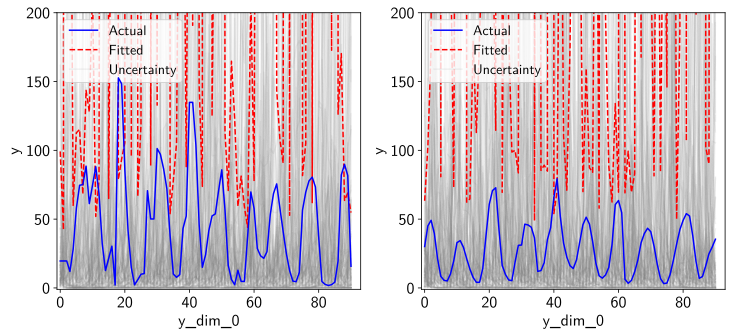

In [145]:
ax_ppc = az.plot_ts(idataprior, y="y", plot_dim="y_dim_0");
for ax in ax_ppc[0]:
    ax.set_xlim([-1, 93])
    ax.set_ylim([-1, 200])

#### Characterize posterior distribution

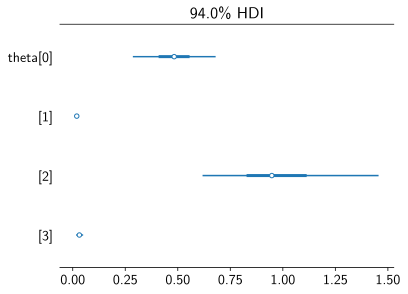

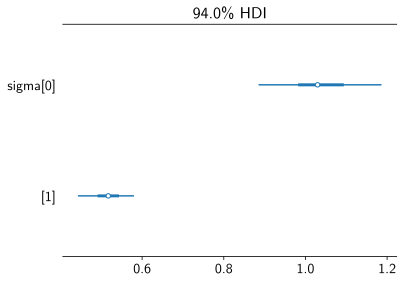

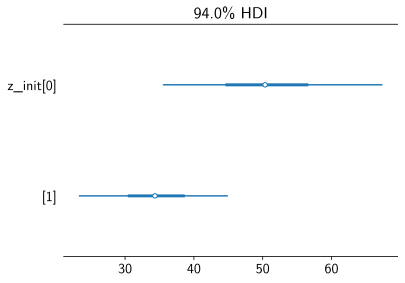

In [126]:
az.plot_forest(inferencedata, var_names=["theta"]);
az.plot_forest(inferencedata, var_names=["sigma"]);
az.plot_forest(inferencedata, var_names=["z_init"]);

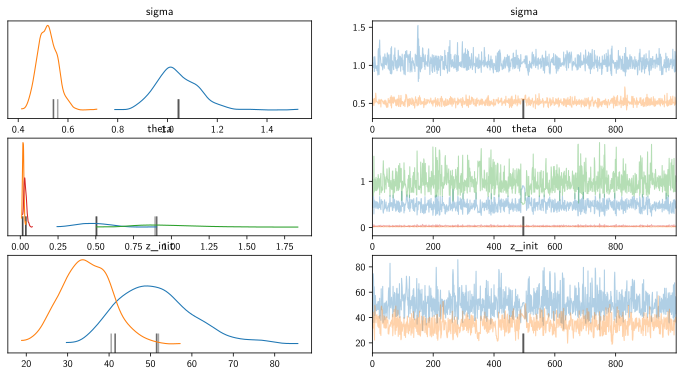

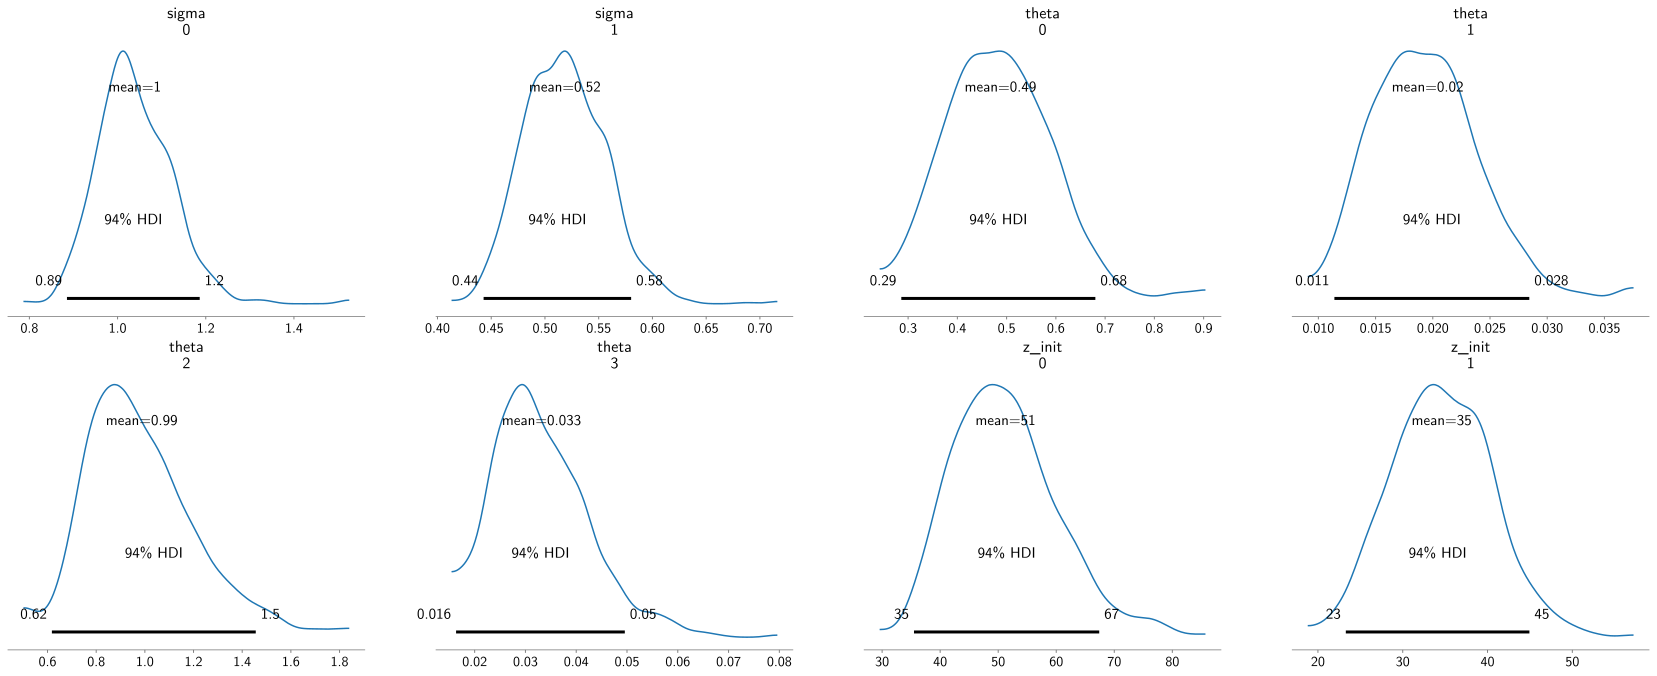

In [127]:

az.plot_trace(inferencedata);
az.plot_posterior(inferencedata, kind="hist", color=light_gray);